In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


## Read and Understand data

In [2]:
original_data=pd.read_csv('train.csv')
original_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data=original_data
data.drop('Id',axis=1,inplace=True)
data.shape

(1460, 80)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [5]:
#GarageYrBlt i feel it is not that much important
#GarageCars whem we have garageArea measure, we dont need to consider this factor
#GarageQual we dont know based on which attribute they measured this and who has measured this
#MSSubClass as thisinformation is given by house style
rem_col=['GarageYrBlt','GarageCars','GarageQual','LotShape','LandSlope','MSSubClass','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageCond','Condition2']
data.drop(rem_col,axis=1,inplace=True)

## Missing value treatment

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
round(100*(data.isna().sum()/data.shape[0]),100)

MSZoning         0.000000 
LotFrontage      17.739726
LotArea          0.000000 
Street           0.000000 
Alley            93.767123
LandContour      0.000000 
Utilities        0.000000 
LotConfig        0.000000 
Neighborhood     0.000000 
Condition1       0.000000 
BldgType         0.000000 
HouseStyle       0.000000 
YearBuilt        0.000000 
YearRemodAdd     0.000000 
RoofStyle        0.000000 
RoofMatl         0.000000 
Exterior1st      0.000000 
Exterior2nd      0.000000 
MasVnrType       0.547945 
MasVnrArea       0.547945 
Foundation       0.000000 
BsmtExposure     2.602740 
BsmtFinType1     2.534247 
BsmtFinSF1       0.000000 
BsmtFinType2     2.602740 
BsmtFinSF2       0.000000 
BsmtUnfSF        0.000000 
TotalBsmtSF      0.000000 
Heating          0.000000 
CentralAir       0.000000 
                   ...    
GrLivArea        0.000000 
BsmtFullBath     0.000000 
BsmtHalfBath     0.000000 
FullBath         0.000000 
HalfBath         0.000000 
BedroomAbvGr     0.000000 
K

In [7]:
data = data.drop(data.columns[data.apply(lambda col: col.isnull().sum()/len(data) > 0.40)], axis=1)
data=data.dropna(axis=0,thresh=0.5*data.shape[1])
data.shape

(1460, 59)

In [8]:
#MasVnrType and MasVnrArea has same missing values,GarageType and GarageFinish has same amount of missing value
#hence we can fill MasVnrType as 'None' and MasVnrArea as so GarageFinish,GarageType to be filled as NA
data['MasVnrType']=data['MasVnrType'].fillna('None')
data['MasVnrArea']=data['MasVnrArea'].fillna(0)
data['GarageFinish']=data['GarageFinish'].fillna('NA')
data['GarageType']=data['GarageType'].fillna('NA')
data['BsmtExposure']=data['BsmtExposure'].fillna('NA')
data['BsmtFinType1']=data['BsmtFinType1'].fillna('NA')
data['BsmtFinType2']=data['BsmtFinType2'].fillna('NA')

(array([205., 643., 298.,  40.,   9.,   4.,   0.,   0.,   0.,   2.]),
 array([ 21. ,  50.2,  79.4, 108.6, 137.8, 167. , 196.2, 225.4, 254.6,
        283.8, 313. ]),
 <a list of 10 Patch objects>)

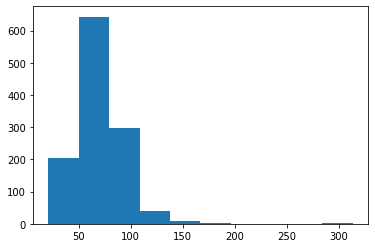

In [9]:
plt.hist(data['LotFrontage'])

In [10]:
data['LotFrontage'].mode()

0    60.0
dtype: float64

In [11]:
#will fill LotFrontage with mode value, since LotFrontage is left skewed 
data['LotFrontage']=data['LotFrontage'].fillna(data['LotFrontage'].mode()[0])
data.dropna(inplace=True)
data.shape

(1459, 59)

(array([205., 901., 298.,  40.,   9.,   4.,   0.,   0.,   0.,   2.]),
 array([ 21. ,  50.2,  79.4, 108.6, 137.8, 167. , 196.2, 225.4, 254.6,
        283.8, 313. ]),
 <a list of 10 Patch objects>)

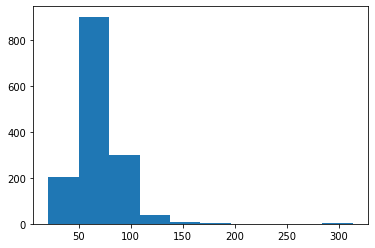

In [12]:
plt.hist(data['LotFrontage'])

### Continues data analysis

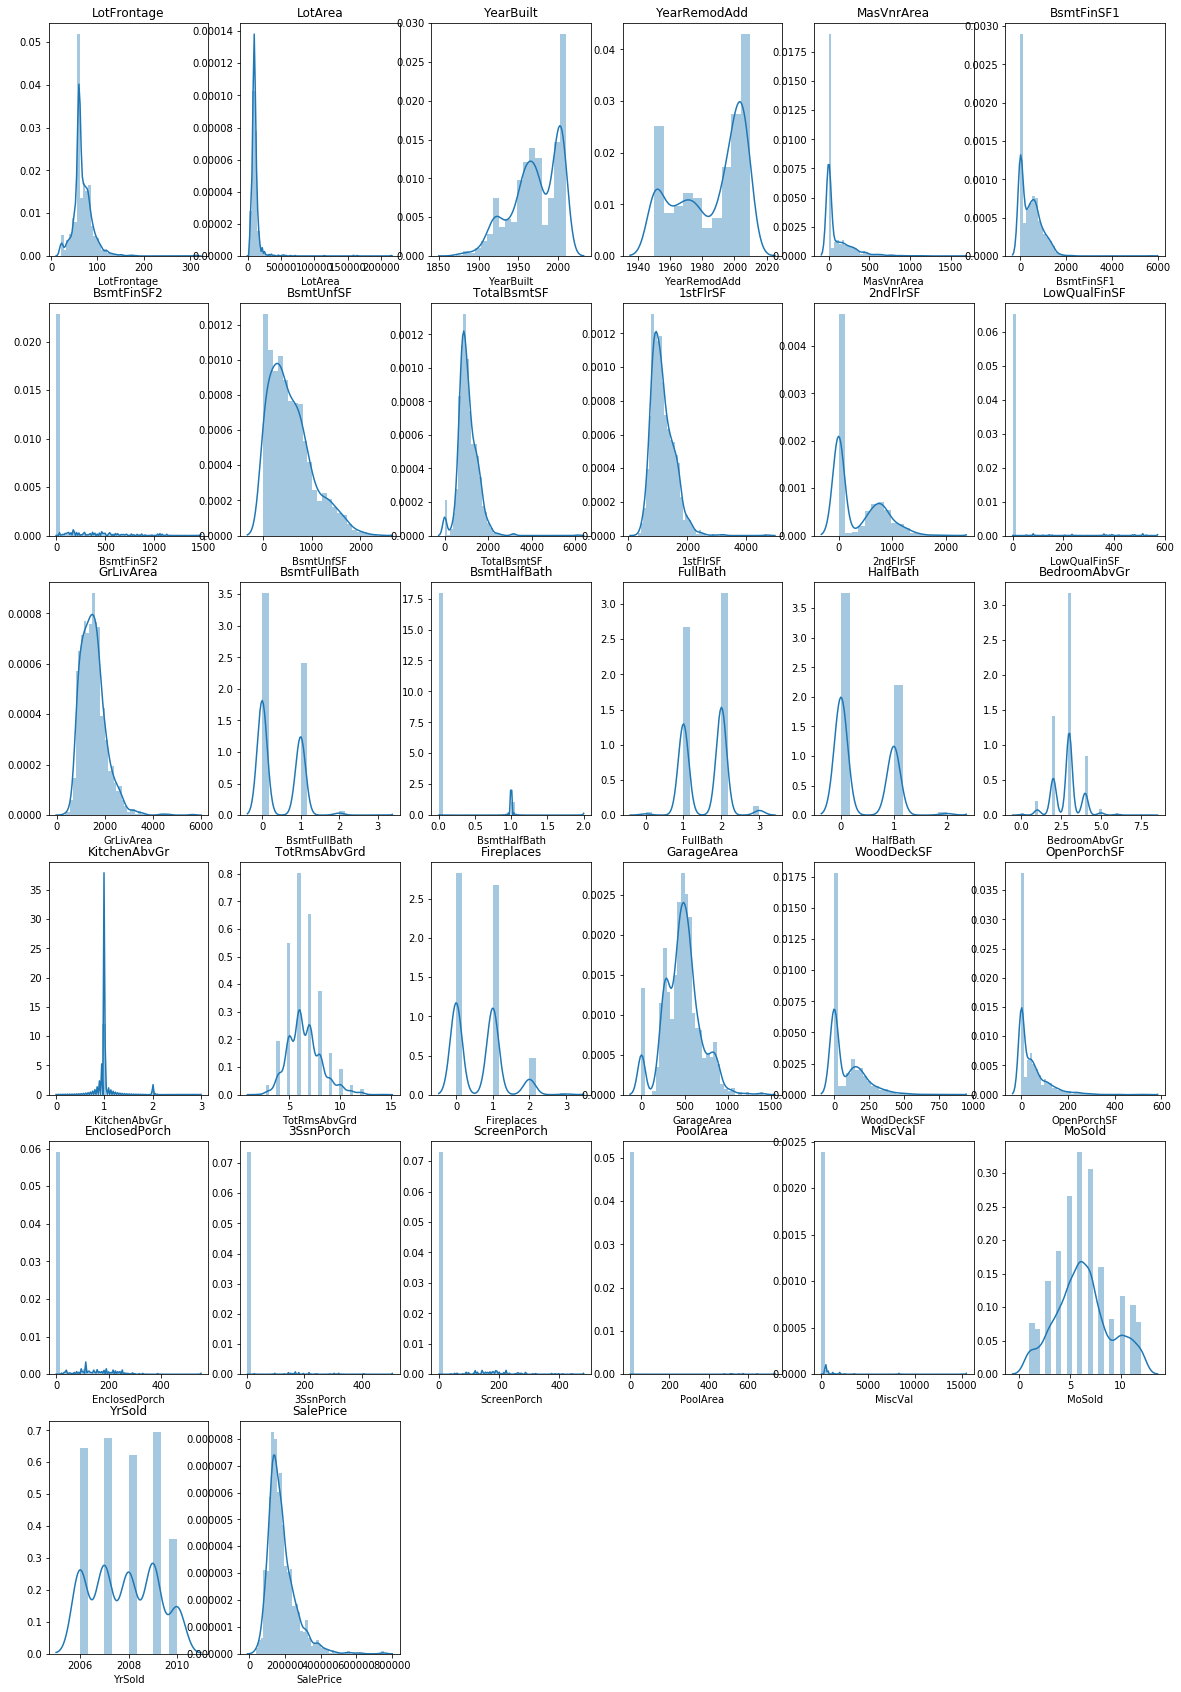

In [13]:
con_data=data.select_dtypes(exclude=['object'])
plt.figure(figsize=(20,30))
i=1
for col in con_data.columns:
    plt.subplot(6,6,i)
    i=i+1
    sns.distplot(con_data[col])
    plt.title(col)

In [14]:
#there are some highly skwed catagorical columns , we will not consider those columns for analysis and also we are dropping the 'MOSold' column
Skewed_col=['MasVnrArea','BsmtFinSF2','LowQualFinSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold']
data.drop(Skewed_col,axis=1,inplace=True)

In [15]:
#there are some catagorical values,which are respreseted as numbers so referd to as continues column. 
#we will convert that nback to catagorical columns
cat_con=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces']
data[cat_con]=data[cat_con].astype(str)

In [16]:
con_data=data.select_dtypes(exclude=['object'])
con_data.shape

(1459, 15)

In [17]:
#Since sales data is highly skewed and that is the target variable, taking logorithm to make normal distribution
data['SalePrice']=np.log(data['SalePrice'])

### year column convertion

In [18]:
##'YearBuilt','YearRemodAdd','YrSold'
##Property_age=YrSold-YearBuilt
##modified_age=YrSold-YearRemodAdd
data['Property_age']=data['YrSold']-data['YearBuilt']
data['modified_age']=data['YrSold']-data['YearRemodAdd']
data.drop(['YrSold','YearBuilt','YearRemodAdd'],axis=1,inplace=True)

## Outlier treatment

In [19]:
#changing the data types of columns, as below three columns are catgorical values
con_data=data.select_dtypes(exclude=['object'])
con_data.head()

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,Property_age,modified_age
0,65.0,8450,706,150,856,856,854,1710,548,0,61,12.247694,5,5
1,80.0,9600,978,284,1262,1262,0,1262,460,298,0,12.109011,31,31
2,68.0,11250,486,434,920,920,866,1786,608,0,42,12.317167,7,6
3,60.0,9550,216,540,756,961,756,1717,642,0,35,11.849398,91,36
4,84.0,14260,655,490,1145,1145,1053,2198,836,192,84,12.429216,8,8


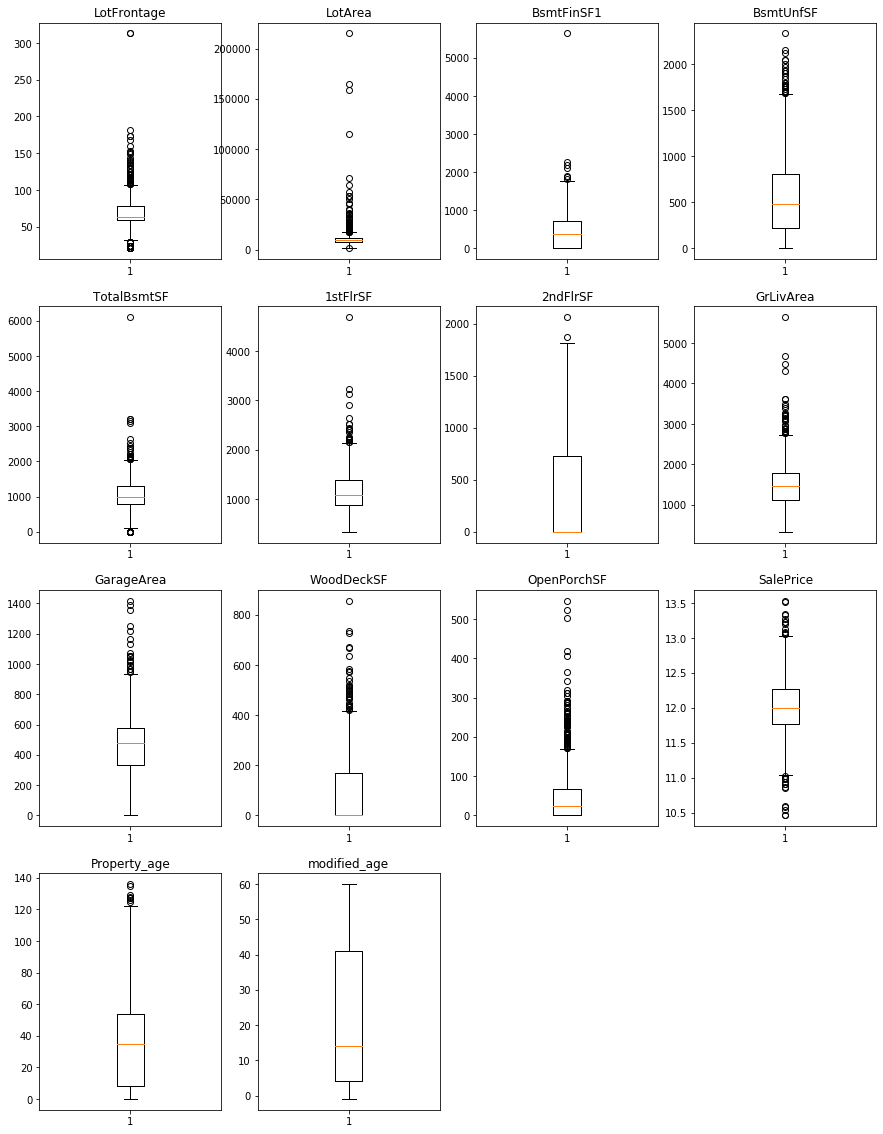

In [20]:
plt.figure(figsize=(15,20))
i=1
for col in con_data.columns:
    plt.subplot(4,4,i)
    i=i+1
    plt.boxplot(data[col])
    plt.title(col)

In [21]:
con_data.describe(percentiles=[0.5,0.7,0.95,0.99])

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,Property_age,modified_age
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,68.263879,10517.363948,443.943797,567.366004,1057.891021,1162.906785,346.791638,1515.546950,473.030158,94.240576,46.692255,12.024048,36.571624,22.965045
std,22.363676,9984.666267,456.106417,441.992392,438.500975,386.572089,436.610637,525.650927,213.869604,125.381679,66.267472,0.399589,30.246986,20.639721
min,21.000000,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,10.460242,0.000000,-1.000000
50%,63.000000,9477.000000,384.000000,479.000000,992.000000,1088.000000,0.000000,1464.000000,480.000000,0.000000,25.000000,12.001505,35.000000,14.000000
70%,75.000000,11068.000000,655.000000,736.000000,1216.000000,1314.000000,672.000000,1709.600000,560.000000,144.000000,57.000000,12.199752,51.000000,37.000000
95%,104.000000,17402.300000,1274.000000,1468.000000,1753.000000,1831.500000,1141.100000,2466.200000,850.200000,335.000000,175.100000,12.695264,91.000000,58.000000
99%,137.420000,37593.680000,1572.420000,1797.100000,2155.100000,2219.520000,1419.040000,3123.760000,1002.980000,505.520000,285.840000,13.000464,110.420000,60.000000
max,313.000000,215245.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,5642.000000,1418.000000,857.000000,547.000000,13.534473,136.000000,60.000000


In [22]:
#Clearly LotArea,BsmtFinSF1 have some outlier
data=data[data.LotArea<data.LotArea.quantile(0.95)]
data.describe(percentiles=[0.5,0.7,0.95,0.99])

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,Property_age,modified_age
count,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000
mean,67.223665,9225.037518,428.594517,568.678211,1040.075036,1143.167388,338.762626,1487.045455,466.254690,90.681818,44.957431,12.009491,36.212121,22.862193
std,19.366365,3169.736252,422.715762,443.006948,408.744338,361.976964,426.676664,486.391633,209.722211,119.796044,63.375111,0.392639,30.263102,20.640199
min,21.000000,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,10.460242,0.000000,0.000000
50%,63.000000,9246.500000,378.000000,479.500000,980.000000,1074.500000,0.000000,1440.500000,474.000000,0.000000,24.000000,11.982929,34.000000,14.000000
70%,75.000000,10745.000000,644.500000,732.000000,1200.000000,1289.500000,668.000000,1690.000000,552.000000,144.000000,56.000000,12.180755,50.500000,37.000000
95%,100.000000,14539.750000,1233.250000,1477.000000,1728.000000,1791.000000,1119.000000,2392.000000,840.000000,323.500000,168.000000,12.676076,91.000000,58.000000
99%,122.300000,16571.250000,1521.300000,1800.000000,2111.650000,2122.200000,1350.200000,2868.600000,948.050000,474.300000,263.800000,12.959937,109.150000,60.000000
max,182.000000,17400.000000,2188.000000,2336.000000,3206.000000,3228.000000,2065.000000,4476.000000,1390.000000,736.000000,547.000000,13.521139,136.000000,60.000000


In [23]:
#MiscVal has some outlier
data=data[data.BsmtFinSF1<data.BsmtFinSF1.quantile(0.99)]
data.describe(percentiles=[0.5,0.7,0.95,0.99])

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,Property_age,modified_age
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,67.040816,9201.442420,415.509475,572.002187,1030.357872,1134.918367,340.714286,1480.800292,463.332362,90.016764,44.914723,12.001779,36.475219,22.993440
std,19.115826,3163.757466,403.920791,443.557787,397.162657,353.158790,425.025308,479.534995,207.735399,119.604261,63.610360,0.385072,30.279059,20.665283
min,21.000000,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,10.460242,0.000000,0.000000
50%,63.000000,9233.000000,372.500000,484.000000,976.000000,1071.500000,0.000000,1435.000000,472.000000,0.000000,24.000000,11.981036,34.500000,14.000000
70%,75.000000,10702.600000,637.000000,734.700000,1192.100000,1276.700000,670.000000,1683.700000,550.000000,144.000000,55.000000,12.175426,51.000000,37.000000
95%,100.000000,14445.600000,1200.000000,1480.900000,1709.450000,1758.300000,1117.800000,2383.200000,837.350000,322.900000,168.000000,12.663916,91.000000,58.000000
99%,122.000000,16581.750000,1413.480000,1800.000000,2035.610000,2073.870000,1347.580000,2839.600000,936.000000,474.580000,265.480000,12.925675,109.290000,60.000000
max,182.000000,17400.000000,1518.000000,2336.000000,3206.000000,3228.000000,1611.000000,3447.000000,1390.000000,736.000000,547.000000,13.275828,136.000000,60.000000


In [24]:
con_data=data.select_dtypes(exclude=['object'])

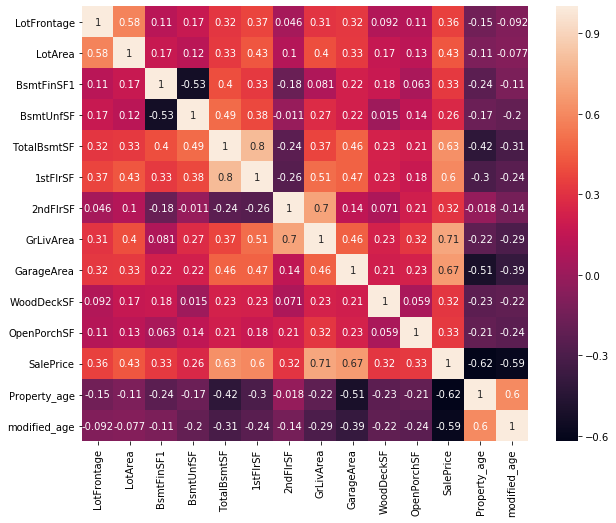

In [25]:
corr=con_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

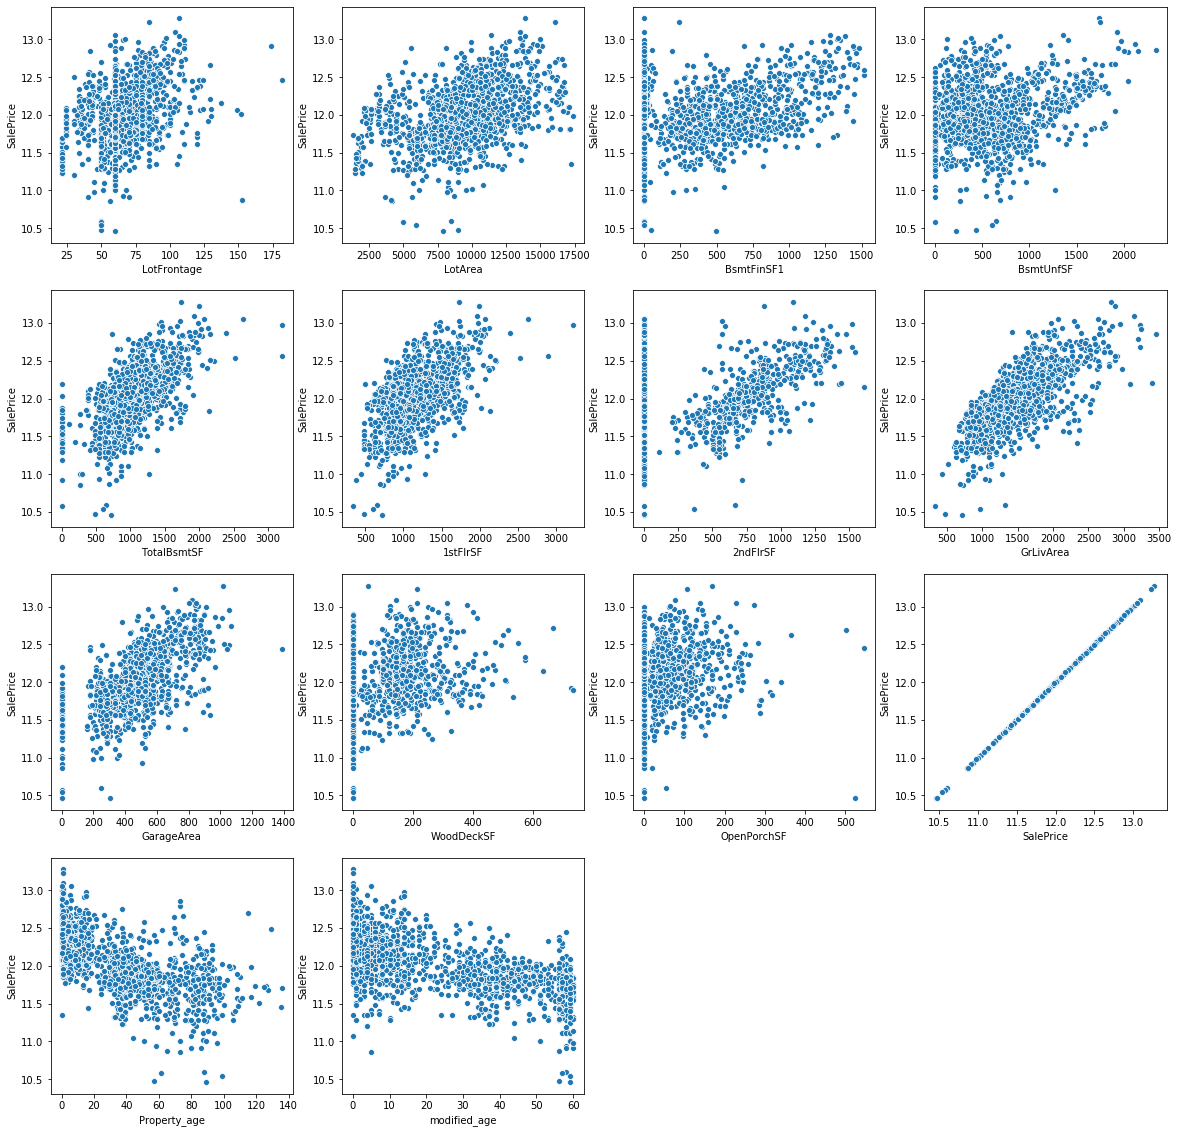

In [26]:
con_data=data.select_dtypes(exclude=['object'])
plt.figure(figsize=(20,20))
i=1
for col in con_data.columns:
    plt.subplot(4,4,i)
    i=i+1
    sns.scatterplot(x=col,y='SalePrice',data=data)
    

### Catgorical data analysis

In [27]:
cat_data=data.select_dtypes(include=['object'])
cat_data.shape

(1372, 35)

In [28]:
cat_data.head()

,MSZoning,Street,LandContour,Utilities,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Lvl,AllPub,Inside,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,No,GLQ,Unf,GasA,Y,SBrkr,1,0,2,1,3,1,8,Typ,0,Attchd,RFn,Y,WD,Normal
1,RL,Pave,Lvl,AllPub,FR2,Veenker,Feedr,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,Gd,ALQ,Unf,GasA,Y,SBrkr,0,1,2,0,3,1,6,Typ,1,Attchd,RFn,Y,WD,Normal
2,RL,Pave,Lvl,AllPub,Inside,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,Mn,GLQ,Unf,GasA,Y,SBrkr,1,0,2,1,3,1,6,Typ,1,Attchd,RFn,Y,WD,Normal
3,RL,Pave,Lvl,AllPub,Corner,Crawfor,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,No,ALQ,Unf,GasA,Y,SBrkr,1,0,1,0,3,1,7,Typ,1,Detchd,Unf,Y,WD,Abnorml
4,RL,Pave,Lvl,AllPub,FR2,NoRidge,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,Av,GLQ,Unf,GasA,Y,SBrkr,1,0,2,1,4,1,9,Typ,1,Attchd,RFn,Y,WD,Normal


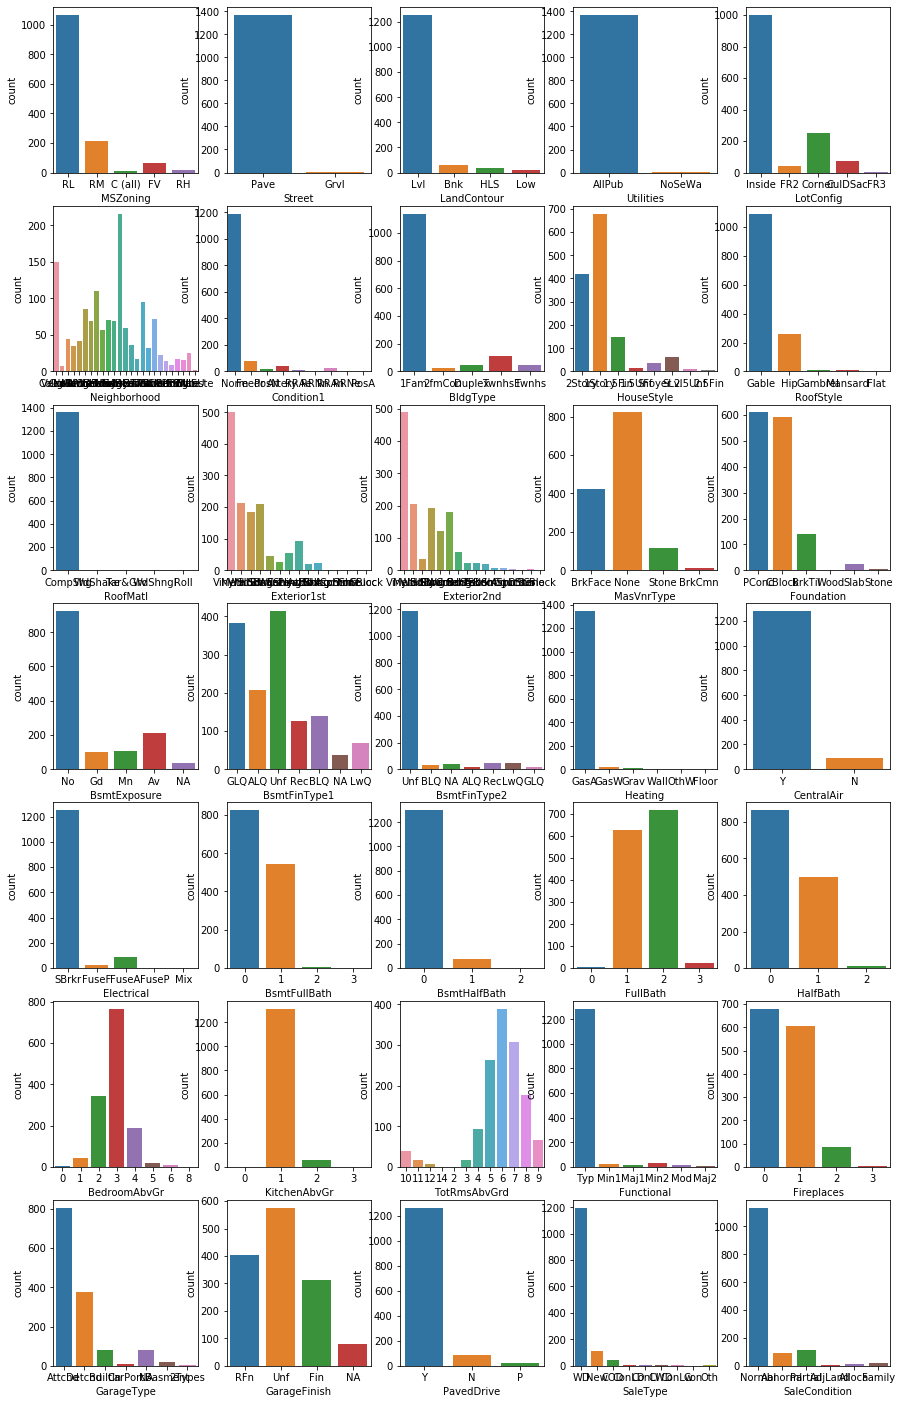

In [29]:

plt.figure(figsize=(15,25))
i=1
for col in cat_data.columns:
    plt.subplot(7,5,i)
    i=i+1
    sns.countplot(x=col,data=cat_data)

In [30]:
for col in cat_data.columns:
    print(data[col].value_counts())
    print('------------------------------------------------------')

RL         1068
RM         214 
FV         65  
RH         16  
C (all)    9   
Name: MSZoning, dtype: int64
------------------------------------------------------
Pave    1369
Grvl    3   
Name: Street, dtype: int64
------------------------------------------------------
Lvl    1256
Bnk    56  
HLS    40  
Low    20  
Name: LandContour, dtype: int64
------------------------------------------------------
AllPub    1371
NoSeWa    1   
Name: Utilities, dtype: int64
------------------------------------------------------
Inside     1002
Corner     248 
CulDSac    74  
FR2        44  
FR3        4   
Name: LotConfig, dtype: int64
------------------------------------------------------
NAmes      216
CollgCr    150
OldTown    110
Edwards    95 
Somerst    85 
Gilbert    72 
Sawyer     70 
NWAmes     69 
NridgHt    69 
SawyerW    59 
BrkSide    57 
Crawfor    45 
Mitchel    41 
IDOTRR     36 
NoRidge    35 
Timber     32 
SWISU      25 
StoneBr    23 
MeadowV    17 
Blmngtn    17 
BrDale     16

In [31]:
data.drop('Utilities',inplace=True,axis=1)

In [32]:
def mapMSZoning(x):
    if x in ['RL','RM']:
        return x
    else:
        return 'other'
    
def mapNeighborhood(x):
    if x in ['Blueste','Veenker','NPkVill','ClearCr','BrDale','Blmngtn','MeadowV','StoneBr','SWISU','Timber','NoRidge','IDOTRR','Mitchel','Crawfor']:
        return 'other'
    else:
        return x 
    
def mapCondition1(x):
    if x in ['Norm']:
        return x
    else:
        return 'other'   

def mapBldgType(x):
    if x in ['1Fam']:
        return x
    else:
        return 'other'
    
def mapBsmtFullBath(x):
    if x in['0','1']:
        return x
    else:
        return 'other'
    
def mapBsmtHalfBath(x):
    if x in['0']:
        return x
    else:
        return 'other' 
    
def mapBsmtHalfBath(x):
    if x in['0']:
        return x
    else:
        return 'other'
    
def mapFullBath(x):
    if x in['1','2']:
        return x
    else:
        return 'other'
    
def mapBedroomAbvGr(x):
    if x in['2','3','4']:
        return x
    else:
        return 'other'    
    
def mapKitchenAbvGr(x):
    if x in['1']:
        return x
    else:
        return 'other'  
    
def mapTotRmsAbvGrd(x):
    if x in['5','6','7','8']:
        return x
    else:
        return 'other'   

def mapFireplaces(x):
    if x in['0','1']:
        return x
    else:
        return 'other'    


In [33]:
def mapLandContour(x):
    if x in ['Lvl']:
        return x
    else:
        return 'other'
    
def mapLotConfig(x):
    if x in ['Inside','Corner']:
        return x
    else:
        return 'other'
    
def mapRoofStyle(x):
    if x in ['Gable','HipRoofMatl']:
        return x
    else:
        return 'other'    
    
def mapRoofMatl(x):
    if x in ['CompShg']:
        return x
    else:
        return 'other'  

def mapExterior1st(x):
    if x in ['AsphShn','ImStucc','CBlock','BrkComm','Stone','AsbShng']:
        return 'other'
    else:
        return x    
    
def mapExterior2nd(x):
    if x in ['Other','CBlock','AsphShn','Stone','Brk Cmn','ImStucc','AsbShng','Stucco','BrkFace','Wd Shng']:
        return 'other'
    else:
        return x 
    
def mapFoundation(x):
    if x in ['Slab','Stone','Wood']:
        return 'other'
    else:
        return x     
    
def mapBsmtFinType2(x):
    if x in ['Unf']:
        return x
    else:
        return 'other'
    
def mapHeating(x):
    if x in ['GasA']:
        return x
    else:
        return 'other'    
    
def mapElectrical(x):
    if x in ['SBrkr']:
        return x
    else:
        return 'other' 
    
def mapFunctional(x):
    if x in ['Typ']:
        return x
    else:
        return 'other'  
    
def mapGarageType(x):
    if x in ['Attchd','Detchd','BuiltIn']:
        return x
    else:
        return 'other'
    
def mapSaleType(x):
    if x in ['WD','New']:
        return x
    else:
        return 'other'
    
def mapSaleCondition(x):
    if x in ['Normal','Partial','Abnorml']:
        return x
    else:
        return 'other'    
    

In [34]:
data['MSZoning']=data['MSZoning'].apply(lambda x:mapMSZoning(x))
data['LotConfig']=data['LotConfig'].apply(lambda x:mapLotConfig(x))
data['RoofStyle']=data['RoofStyle'].apply(lambda x:mapRoofStyle(x))
data['RoofMatl']=data['RoofMatl'].apply(lambda x:mapRoofMatl(x))
data['Exterior1st']=data['Exterior1st'].apply(lambda x:mapExterior1st(x))
data['Exterior2nd']=data['Exterior2nd'].apply(lambda x:mapExterior2nd(x))
data['Foundation']=data['Foundation'].apply(lambda x:mapFoundation(x))
data['BsmtFinType2']=data['BsmtFinType2'].apply(lambda x:mapBsmtFinType2(x))
data['Heating']=data['Heating'].apply(lambda x:mapHeating(x))
data['Electrical']=data['Electrical'].apply(lambda x:mapElectrical(x))
data['Functional']=data['Functional'].apply(lambda x:mapFunctional(x))
data['GarageType']=data['GarageType'].apply(lambda x:mapGarageType(x))
data['SaleType']=data['SaleType'].apply(lambda x:mapSaleType(x))
data['SaleCondition']=data['SaleCondition'].apply(lambda x:mapSaleCondition(x))
data['LandContour']=data['LandContour'].apply(lambda x:mapLandContour(x))
data['Neighborhood']=data['Neighborhood'].apply(lambda x:mapNeighborhood(x))
data['Condition1']=data['Condition1'].apply(lambda x:mapCondition1(x))
data['BldgType']=data['BldgType'].apply(lambda x:mapBldgType(x))
data['BsmtFullBath']=data['BsmtFullBath'].apply(lambda x:mapBsmtFullBath(x))
data['BsmtHalfBath']=data['BsmtHalfBath'].apply(lambda x:mapBsmtHalfBath(x))
data['FullBath']=data['FullBath'].apply(lambda x:mapFullBath(x))
data['BedroomAbvGr']=data['BedroomAbvGr'].apply(lambda x:mapBedroomAbvGr(x))
data['KitchenAbvGr']=data['KitchenAbvGr'].apply(lambda x:mapKitchenAbvGr(x))
data['TotRmsAbvGrd']=data['TotRmsAbvGrd'].apply(lambda x:mapTotRmsAbvGrd(x))
data['Fireplaces']=data['Fireplaces'].apply(lambda x:mapFireplaces(x))

### Creating dummy variable

In [35]:
cat_data=data.select_dtypes(include=['object'])
dummy=pd.get_dummies(cat_data)
dummy_col=['MSZoning_other','RoofStyle_other','LotConfig_other','RoofMatl_other','Exterior1st_other','Exterior2nd_other','BsmtFinType2_other','Heating_other','Electrical_other','Functional_other','GarageType_other',
           'SaleType_other','SaleCondition_other','Foundation_other','Street_Grvl','LandContour_other','Neighborhood_other','BldgType_other','Condition1_other','HouseStyle_2.5Fin','MasVnrType_BrkCmn','BsmtExposure_NA','BsmtFinType1_NA',
           'CentralAir_N','HalfBath_2','GarageFinish_NA','PavedDrive_P','BsmtFullBath_other','BsmtHalfBath_other','FullBath_other','BedroomAbvGr_other','KitchenAbvGr_other','TotRmsAbvGrd_other','Fireplaces_other']
dummy.drop(dummy_col,axis=1,inplace=True)
dummy.shape

(1372, 94)

In [36]:
dummy.head()

,MSZoning_RL,MSZoning_RM,Street_Pave,LandContour_Lvl,LotConfig_Corner,LotConfig_Inside,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,Heating_GasA,CentralAir_Y,Electrical_SBrkr,BsmtFullBath_0,BsmtFullBath_1,BsmtHalfBath_0,FullBath_1,FullBath_2,HalfBath_0,HalfBath_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,KitchenAbvGr_1,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,Functional_Typ,Fireplaces_0,Fireplaces_1,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0
1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0
2,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0
3,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0
4,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,1,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0


In [37]:
data.drop(cat_data.columns,axis=1,inplace=True)
data=pd.concat([data,dummy],axis=1)
data.shape

(1372, 108)

In [38]:
df_train,df_test=train_test_split(data,train_size=0.7,random_state=100)
df_train.shape

(960, 108)

In [39]:
y_train=df_train.pop('SalePrice')
X_train=df_train

In [40]:
y_test=df_test.pop('SalePrice')
X_test=df_test

In [41]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(X_train)
x_train=pd.DataFrame(scaled_data)
x_train.columns=X_train.columns
x_train.head()

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,Property_age,modified_age,MSZoning_RL,MSZoning_RM,Street_Pave,LandContour_Lvl,LotConfig_Corner,LotConfig_Inside,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,Heating_GasA,CentralAir_Y,Electrical_SBrkr,BsmtFullBath_0,BsmtFullBath_1,BsmtHalfBath_0,FullBath_1,FullBath_2,HalfBath_0,HalfBath_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,KitchenAbvGr_1,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,Functional_Typ,Fireplaces_0,Fireplaces_1,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,0.242236,0.448447,0.110672,0.000000,0.222707,0.452381,0.535071,0.693918,0.202058,0.119565,0.027422,0.674074,0.950000,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.366460,0.566522,0.259552,0.250856,0.305677,0.212885,0.455618,0.424061,0.463985,0.309783,0.120658,0.162963,0.366667,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.242236,0.688447,0.000000,0.339469,0.247349,0.269608,0.492241,0.497507,0.514500,0.000000,0.206581,0.229630,0.516667,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.242236,0.426832,0.110013,0.298373,0.269495,0.172269,0.000000,0.141575,0.535080,0.000000,0.000000,0.377778,0.266667,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.161491,0.932981,0.841238,0.088613,0.462882,0.429972,0.000000,0.386175,0.298410,0.391304,0.471664,0.362963,0.150000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [42]:
scaled_data=scaler.transform(X_test)
x_test=pd.DataFrame(scaled_data)
x_test.columns=X_test.columns
x_test.head()

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,Property_age,modified_age,MSZoning_RL,MSZoning_RM,Street_Pave,LandContour_Lvl,LotConfig_Corner,LotConfig_Inside,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,Heating_GasA,CentralAir_Y,Electrical_SBrkr,BsmtFullBath_0,BsmtFullBath_1,BsmtHalfBath_0,FullBath_1,FullBath_2,HalfBath_0,HalfBath_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,KitchenAbvGr_1,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,Functional_Typ,Fireplaces_0,Fireplaces_1,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,0.391304,0.545590,0.015810,0.654110,0.484092,0.413165,0.000000,0.370223,0.731525,0.195652,0.036563,0.007407,0.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.273292,0.680559,0.036891,0.512842,0.411104,0.334734,0.746741,0.695580,0.703461,0.301630,0.179159,0.088889,0.200000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.242236,0.486025,0.000000,0.164384,0.119775,0.154062,0.415891,0.346959,0.366698,0.135870,0.045704,0.111111,0.250000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.242236,0.129068,0.000000,0.278682,0.203057,0.117297,0.423340,0.316052,0.224509,0.000000,0.000000,0.466667,0.283333,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.242236,0.539814,0.735178,0.070634,0.399563,0.436975,0.000000,0.392822,0.458372,0.163043,0.142596,0.244444,0.266667,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [43]:
#to find highly corelated values manually and removing them, we can replace this step by RFE also
for col1 in x_train.columns:
    for col2 in x_train.columns:
        c=abs(x_train[col1].corr(x_train[col2]))
        if c>0.8:
            if(col1!=col2):
                print("{} and {}  :{}".format(col1,col2,c))

2ndFlrSF and HouseStyle_2Story  :0.8114797932644655
HouseStyle_2Story and 2ndFlrSF  :0.8114797932644654
Exterior1st_CemntBd and Exterior2nd_CmentBd  :0.9703474903474903
Exterior1st_HdBoard and Exterior2nd_HdBoard  :0.8973742766668557
Exterior1st_MetalSd and Exterior2nd_MetalSd  :0.9733218902181187
Exterior1st_VinylSd and Exterior2nd_VinylSd  :0.973147860877778
Exterior1st_Wd Sdng and Exterior2nd_Wd Sdng  :0.8450263371827212
Exterior2nd_CmentBd and Exterior1st_CemntBd  :0.9703474903474903
Exterior2nd_HdBoard and Exterior1st_HdBoard  :0.8973742766668555
Exterior2nd_MetalSd and Exterior1st_MetalSd  :0.9733218902181188
Exterior2nd_VinylSd and Exterior1st_VinylSd  :0.973147860877778
Exterior2nd_Wd Sdng and Exterior1st_Wd Sdng  :0.8450263371827211
MasVnrType_BrkFace and MasVnrType_None  :0.8266787062684541
MasVnrType_None and MasVnrType_BrkFace  :0.8266787062684541
BsmtFullBath_0 and BsmtFullBath_1  :0.9892486371702875
BsmtFullBath_1 and BsmtFullBath_0  :0.9892486371702874
FullBath_1 and Ful

In [44]:
#will drop highly corelated values
high_corr_value=['1stFlrSF','2ndFlrSF','MSZoning_RM','Exterior2nd_CmentBd','Exterior2nd_HdBoard','Exterior2nd_MetalSd','Exterior2nd_VinylSd','Exterior2nd_Wd Sdng','MasVnrType_None','BsmtFullBath_1','FullBath_2','HalfBath_1','Fireplaces_1','PavedDrive_N','SaleCondition_Partial']
x_train.drop(high_corr_value,axis=1,inplace=True)
x_test.drop(high_corr_value,axis=1,inplace=True)

## Model building

#### Lasso regression

In [45]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()

# cross validation
folds = 5

model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [46]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

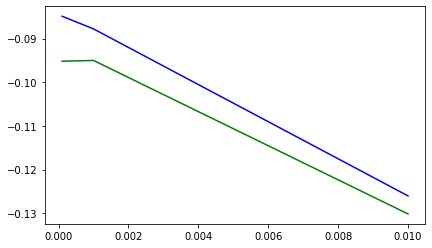

In [47]:

cv_results = cv_results[cv_results['param_alpha']<=0.025]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'],'b')
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'],'g')


In [48]:
#so the final lasso model will be

lasso_final=Lasso(alpha=0.001)
lasso_model=lasso_final.fit(x_train,y_train)
y_train_pred_lasso=lasso_model.predict(x_train)

In [49]:
lasso_train_r2=r2_score(y_train,y_train_pred_lasso)
lasso_train_r2

0.8964402304137021

In [50]:
y_test_pred_lasso=lasso_model.predict(x_test)
lasso_test_r2=r2_score(y_test,y_test_pred_lasso)
lasso_test_r2

0.8858077401984282

In [51]:
#it is a good model
lasso_final.coef_

array([ 0.00000000e+00,  1.11218525e-01,  8.23234629e-02,  0.00000000e+00,
        3.80121691e-01,  9.61592265e-01,  2.10799048e-01,  2.26244145e-02,
        0.00000000e+00, -7.43218589e-02, -1.59588353e-01,  6.24250381e-02,
        0.00000000e+00, -1.31919123e-02,  0.00000000e+00, -1.15486880e-04,
        3.21685487e-02, -0.00000000e+00, -3.86327944e-02, -1.18018231e-02,
       -0.00000000e+00, -0.00000000e+00,  6.64136224e-02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  1.08057831e-01,  3.89218360e-02,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -4.45421920e-04,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -7.93130747e-03,  0.00000000e+00,  7.55059584e-02,  0.00000000e+00,
       -0.00000000e+00,  1.27937978e-02, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -1.03760014e-02,
        1.81201333e-02,  3.32791413e-02,  0.00000000e+00, -2.71314786e-02,
        3.30809941e-02,  

#### Ridge Regression

In [52]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5

model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [53]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009607,0.001358,0.003202,0.000400,0.0001,{'alpha': 0.0001},-0.091508,-0.103099,-0.098522,-0.092958,-0.095990,-0.096415,0.004131,14,-0.085096,-0.084053,-0.084427,-0.084865,-0.084006,-0.084490,0.000433
1,0.005201,0.001169,0.001801,0.000400,0.001,{'alpha': 0.001},-0.091509,-0.103074,-0.098522,-0.092953,-0.095987,-0.096409,0.004124,13,-0.085097,-0.084053,-0.084427,-0.084864,-0.084006,-0.084489,0.000433
2,0.004404,0.000802,0.001400,0.000490,0.01,{'alpha': 0.01},-0.091523,-0.102833,-0.098521,-0.092909,-0.095959,-0.096349,0.004051,12,-0.085106,-0.084051,-0.084418,-0.084850,-0.084010,-0.084487,0.000433
3,0.005406,0.000490,0.002601,0.000800,0.05,{'alpha': 0.05},-0.091562,-0.101938,-0.098544,-0.092735,-0.095876,-0.096131,0.003795,11,-0.085156,-0.084089,-0.084408,-0.084800,-0.084029,-0.084496,0.000429
4,0.007208,0.002487,0.002199,0.000401,0.1,{'alpha': 0.1},-0.091580,-0.101103,-0.098561,-0.092584,-0.095798,-0.095925,0.003572,8,-0.085219,-0.084203,-0.084408,-0.084775,-0.084043,-0.084530,0.000423


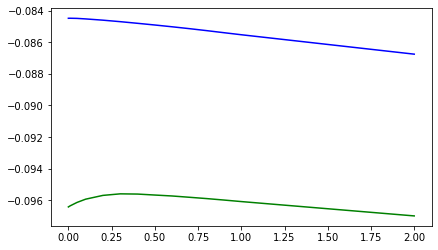

In [54]:

cv_results = cv_results[cv_results['param_alpha']<=2]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'],'b')
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'],'g')


In [55]:
#alpha=0.25

In [56]:
#so the final ridge model will be

ridge_final=Ridge(alpha=0.25)
ridge_model=ridge_final.fit(x_train,y_train)
y_train_pred_ridge=ridge_model.predict(x_train)

In [57]:
ridge_train_r2=r2_score(y_train,y_train_pred_ridge)
ridge_train_r2

0.9052222080886999

In [58]:
y_test_pred_ridge=ridge_model.predict(x_test)
ridge_test_r2=r2_score(y_test,y_test_pred_ridge)
ridge_test_r2

0.8822810654672348

In [59]:
ridge_final.coef_

array([ 5.33624429e-02,  1.45887323e-01,  7.52022115e-02, -3.93221014e-03,
        3.82452419e-01,  1.02860710e+00,  1.56667059e-01,  4.68781177e-02,
        5.81114918e-02, -1.29543046e-01, -1.41633301e-01,  6.96616087e-02,
        7.92920797e-02, -2.09515556e-02, -2.08214898e-03, -5.74134958e-03,
        5.35379940e-02, -1.72576927e-02, -5.52849233e-02, -4.52524011e-02,
       -3.05031296e-02, -2.89899074e-02,  6.21703993e-02, -1.22385432e-02,
       -1.08593768e-02, -2.50279387e-02,  1.11984643e-01,  4.36770421e-02,
       -2.29354778e-02,  7.43697501e-02,  1.98356840e-01,  8.25738435e-02,
        1.71000971e-01,  8.31787232e-02,  1.01067938e-01,  9.72613946e-02,
       -7.10699996e-03,  3.83389848e-04,  1.80709090e-01,  5.40393080e-02,
        4.93936138e-02,  7.51518019e-02,  4.64053072e-02,  1.35461626e-01,
        5.74481396e-02,  6.15475355e-02,  8.70625379e-02, -2.01803899e-02,
        2.11956342e-02,  3.83571894e-02, -1.93874668e-03, -2.74171531e-02,
        2.31042401e-02,  

In [60]:
#keeping coefficients in data frame 
coeff=pd.DataFrame([lasso_final.coef_,ridge_final.coef_])
coeff.columns=x_train.columns
coeff.index=['Lasso','Ridge']
coeff.head()

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,Property_age,modified_age,MSZoning_RL,Street_Pave,LandContour_Lvl,LotConfig_Corner,LotConfig_Inside,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_Plywood,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,Heating_GasA,CentralAir_Y,Electrical_SBrkr,BsmtFullBath_0,BsmtHalfBath_0,FullBath_1,HalfBath_0,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,KitchenAbvGr_1,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,Functional_Typ,Fireplaces_0,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal
Lasso,0.000000,0.111219,0.082323,0.000000,0.380122,0.961592,0.210799,0.022624,0.000000,-0.074322,-0.159588,0.062425,0.000000,-0.013192,0.000000,-0.000115,0.032169,-0.000000,-0.038633,-0.011802,-0.000000,-0.00000,0.066414,-0.000000,-0.000000,-0.000000,0.108058,0.038922,0.000000,-0.00000,0.000000,-0.000445,0.000000,0.000000,-0.000000,0.000000,-0.007931,0.000000,0.075506,0.000000,-0.000000,0.012794,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.010376,0.018120,0.033279,0.000000,-0.027131,0.033081,0.020513,0.054663,-0.000000,-0.010116,0.001697,0.000000,0.018995,-0.009421,-0.000000,-0.010761,0.000000,0.000000,0.121911,0.000000,-0.026791,-0.000368,-0.005804,-0.026108,0.027554,0.024421,0.000000,0.053164,-0.000000,0.001119,0.002899,0.000000,0.100399,-0.060275,0.051396,0.027150,0.027878,0.009185,0.004400,0.000000,0.038474,0.066081,-0.008665,-0.089449,0.009313
Ridge,0.053362,0.145887,0.075202,-0.003932,0.382452,1.028607,0.156667,0.046878,0.058111,-0.129543,-0.141633,0.069662,0.079292,-0.020952,-0.002082,-0.005741,0.053538,-0.017258,-0.055285,-0.045252,-0.030503,-0.02899,0.062170,-0.012239,-0.010859,-0.025028,0.111985,0.043677,-0.022935,0.07437,0.198357,0.082574,0.171001,0.083179,0.101068,0.097261,-0.007107,0.000383,0.180709,0.054039,0.049394,0.075152,0.046405,0.135462,0.057448,0.061548,0.087063,-0.020180,0.021196,0.038357,-0.001939,-0.027417,0.023104,0.055361,0.090104,0.023902,0.019774,-0.013257,-0.013852,-0.009307,-0.052773,-0.033421,-0.040199,-0.000893,0.053913,0.117066,0.005809,-0.031723,-0.026556,-0.000855,-0.022585,0.067975,0.052770,0.019796,0.069288,0.000879,0.013338,0.022663,0.022498,0.120893,-0.042132,0.081197,0.072075,0.068215,0.014020,0.012127,0.009669,0.033043,0.072360,-0.030827,-0.076775,0.035835


In [61]:
coeff_transposed=coeff.T

In [62]:
coeff_transposed=coeff_transposed.reset_index()
coeff_transposed.head()

,index,Lasso,Ridge
0,LotFrontage,0.000000,0.053362
1,LotArea,0.111219,0.145887
2,BsmtFinSF1,0.082323,0.075202
3,BsmtUnfSF,0.000000,-0.003932
4,TotalBsmtSF,0.380122,0.382452


In [63]:
#Top coefficent selected by lasso regression are
coeff_transposed.sort_values(by=['Lasso'],ascending=False)

,index,Lasso,Ridge
5,GrLivArea,0.961592,1.028607
4,TotalBsmtSF,0.380122,0.382452
6,GarageArea,0.210799,0.156667
65,CentralAir_Y,0.121911,0.117066
1,LotArea,0.111219,0.145887
26,Neighborhood_Somerst,0.108058,0.111985
79,Functional_Typ,0.100399,0.120893
2,BsmtFinSF1,0.082323,0.075202
38,Exterior1st_BrkFace,0.075506,0.180709
22,Neighborhood_NridgHt,0.066414,0.062170


In [64]:
#Top coefficent selected by Ridge regression are
coeff_transposed.sort_values(by=['Ridge'],ascending=False).drop('Lasso',axis=1)

,index,Ridge
5,GrLivArea,1.028607
4,TotalBsmtSF,0.382452
30,HouseStyle_1.5Unf,0.198357
38,Exterior1st_BrkFace,0.180709
32,HouseStyle_2.5Unf,0.171001
6,GarageArea,0.156667
1,LotArea,0.145887
43,Exterior1st_Stucco,0.135462
79,Functional_Typ,0.120893
65,CentralAir_Y,0.117066


In [65]:
#When top 5 variable is not available. then the model will be

In [66]:
x_train_lasso_2=x_train.drop(['GrLivArea','TotalBsmtSF','GarageArea','CentralAir_Y','Neighborhood_Somerst'],axis=1)
x_test_lasso_2=x_test.drop(['GrLivArea','TotalBsmtSF','GarageArea','CentralAir_Y','Neighborhood_Somerst'],axis=1)
x_train_ridge_2=x_train.drop(['GrLivArea','TotalBsmtSF','GarageArea','Exterior1st_BrkFace','HouseStyle_1.5Unf'],axis=1)
x_test_ridge_2=x_test.drop(['GrLivArea','TotalBsmtSF','GarageArea','Exterior1st_BrkFace','HouseStyle_1.5Unf'],axis=1)

In [67]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()

# cross validation
folds = 5

model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train_lasso_2, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [68]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.037226,0.017303,0.002607,0.000798,0.0001,{'alpha': 0.0001},-0.113538,-0.125466,-0.121489,-0.113908,-0.117685,-0.118417,0.004556,2,-0.105608,-0.102127,-0.103183,-0.104632,-0.103637,-0.103837,0.001196
1,0.015014,0.003281,0.001797,0.000756,0.001,{'alpha': 0.001},-0.107900,-0.121556,-0.122906,-0.117101,-0.112889,-0.116470,0.005549,1,-0.107841,-0.104628,-0.105783,-0.107006,-0.106703,-0.106392,0.001100
2,0.005600,0.000489,0.001804,0.000403,0.01,{'alpha': 0.01},-0.149093,-0.149855,-0.154270,-0.153511,-0.173525,-0.156051,0.008964,3,-0.151996,-0.149973,-0.150989,-0.150288,-0.151014,-0.150852,0.000699
3,0.005205,0.000747,0.001398,0.000494,0.05,{'alpha': 0.05},-0.208552,-0.223945,-0.208193,-0.211332,-0.242146,-0.218834,0.012999,4,-0.219829,-0.215074,-0.218028,-0.219988,-0.216352,-0.217854,0.001922
4,0.004606,0.000493,0.001394,0.000490,0.1,{'alpha': 0.1},-0.282186,-0.294760,-0.262355,-0.275148,-0.320296,-0.286949,0.019697,5,-0.287721,-0.284229,-0.287295,-0.289053,-0.283931,-0.286446,0.002019


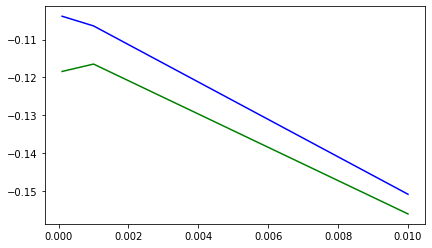

In [69]:

cv_results = cv_results[cv_results['param_alpha']<=0.025]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'],'b')
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'],'g')


In [70]:
#so the final lasso model will be

lasso_final=Lasso(alpha=0.001)
lasso_model=lasso_final.fit(x_train_lasso_2,y_train)
y_train_pred_lasso=lasso_model.predict(x_train_lasso_2)

In [71]:
lasso_train_r2=r2_score(y_train,y_train_pred_lasso)
lasso_train_r2

0.8512012895634615

In [72]:
y_test_pred_lasso=lasso_model.predict(x_test_lasso_2)
lasso_test_r2=r2_score(y_test,y_test_pred_lasso)
lasso_test_r2

0.8537676524727816

In [73]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5

model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train_ridge_2, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [74]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006607,0.001019,0.002601,0.000491,0.0001,{'alpha': 0.0001},-0.112052,-0.124287,-0.123022,-0.110853,-0.114185,-0.116880,0.005648,18,-0.103660,-0.101019,-0.101232,-0.103860,-0.102063,-0.102367,0.001192
1,0.008008,0.002686,0.002200,0.000402,0.001,{'alpha': 0.001},-0.112051,-0.124288,-0.123019,-0.110853,-0.114184,-0.116879,0.005647,17,-0.103663,-0.101021,-0.101232,-0.103863,-0.102064,-0.102369,0.001192
2,0.006806,0.000753,0.001799,0.000399,0.01,{'alpha': 0.01},-0.112050,-0.124294,-0.122986,-0.110854,-0.114173,-0.116871,0.005643,16,-0.103686,-0.101037,-0.101229,-0.103889,-0.102079,-0.102384,0.001200
3,0.007806,0.000748,0.002401,0.000491,0.05,{'alpha': 0.05},-0.112032,-0.124300,-0.122847,-0.110850,-0.114110,-0.116828,0.005624,15,-0.103748,-0.101070,-0.101217,-0.103961,-0.102113,-0.102422,0.001225
4,0.010010,0.002900,0.002602,0.000804,0.1,{'alpha': 0.1},-0.111992,-0.124272,-0.122686,-0.110838,-0.114025,-0.116763,0.005601,13,-0.103783,-0.101080,-0.101205,-0.104013,-0.102118,-0.102440,0.001246


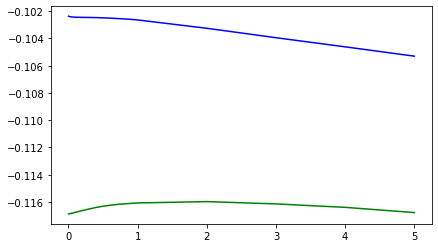

In [75]:

cv_results = cv_results[cv_results['param_alpha']<=5]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'],'b')
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'],'g')


In [76]:
#so the final ridge model will be

ridge_final=Ridge(alpha=0.25)
ridge_model=ridge_final.fit(x_train_ridge_2,y_train)
y_train_pred_ridge=ridge_model.predict(x_train_ridge_2)

In [77]:
ridge_train_r2=r2_score(y_train,y_train_pred_ridge)
ridge_train_r2

0.8643036827803932

In [78]:
y_test_pred_ridge=ridge_model.predict(x_test_ridge_2)
ridge_test_r2=r2_score(y_test,y_test_pred_ridge)
ridge_test_r2

0.8618121909665806

In [79]:
#keeping coefficients in data frame 
coeff=pd.DataFrame([lasso_final.coef_,ridge_final.coef_])
coeff.columns=x_test_ridge_2.columns
coeff.index=['Lasso','Ridge']
coeff.head()

,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,WoodDeckSF,OpenPorchSF,Property_age,modified_age,MSZoning_RL,Street_Pave,LandContour_Lvl,LotConfig_Corner,LotConfig_Inside,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Norm,BldgType_1Fam,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofMatl_CompShg,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_Plywood,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Unf,Heating_GasA,CentralAir_Y,Electrical_SBrkr,BsmtFullBath_0,BsmtHalfBath_0,FullBath_1,HalfBath_0,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,KitchenAbvGr_1,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,Functional_Typ,Fireplaces_0,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal
Lasso,0.008466,0.250027,0.456736,0.631781,0.028549,0.067557,-0.022240,-0.226693,0.033075,0.000000,-0.030783,0.008756,-0.000000,0.018900,-0.026308,-0.064197,-0.117132,-0.000000,-0.009372,0.059272,-0.005715,-0.000000,-0.000000,0.017907,0.024657,0.000000,0.000000,-0.085265,0.000000,0.030073,-0.033983,-0.000000,-0.031178,-0.000000,0.116728,0.00000,-0.002486,0.021330,-0.000000,0.042618,0.000000,-0.000000,-0.000000,-0.00000,0.028842,0.054201,-0.000000,-0.039816,0.049453,0.000000,0.042337,0.00000,-0.019848,-0.010886,0.000000,0.017922,0.000000,0.000000,-0.027778,-0.087826,0.052700,0.003921,-0.041461,-0.00000,-0.098228,-0.093199,-0.000000,0.000000,0.025386,0.027310,-0.026381,-0.022107,-0.000000,0.003749,0.068609,-0.093334,0.056961,0.108950,0.041019,0.085596,0.088891,0.073656,0.084698,0.034574,-0.055166,-0.098642,0.000000
Ridge,0.097100,0.239927,0.494247,0.688603,0.066088,0.123689,-0.013103,-0.195858,0.065501,0.024381,-0.043133,0.021673,0.006741,0.037438,-0.039286,-0.084444,-0.127573,-0.027022,-0.046606,0.063537,-0.026884,-0.029947,-0.036273,0.088532,0.024720,-0.002635,-0.024523,-0.130146,0.104805,0.009126,-0.115091,-0.062006,-0.034607,-0.003929,-0.072195,-0.08518,-0.057957,-0.098235,0.053135,-0.073057,-0.068846,-0.075018,0.012323,0.03612,0.044747,-0.053277,-0.087558,-0.018064,0.026500,0.078539,0.018024,0.00213,-0.044019,-0.030836,-0.017579,-0.021149,-0.039933,-0.058693,-0.107987,0.032668,0.160604,0.002070,-0.047307,-0.02332,-0.090047,-0.078219,0.013529,0.017178,0.032819,0.041577,-0.044948,-0.033428,-0.014611,0.005153,0.080382,-0.074894,0.042890,0.111524,0.030560,0.128034,0.130549,0.120661,0.057637,0.026796,-0.068669,-0.095030,0.019905


In [80]:
coeff_transposed=coeff.T
coeff_transposed=coeff_transposed.reset_index()
coeff_transposed.head()

,index,Lasso,Ridge
0,LotFrontage,0.008466,0.097100
1,LotArea,0.250027,0.239927
2,BsmtFinSF1,0.456736,0.494247
3,BsmtUnfSF,0.631781,0.688603
4,WoodDeckSF,0.028549,0.066088


In [81]:
#Top coefficent selected by lasso regression are
coeff_transposed.sort_values(by=['Lasso'],ascending=False)

,index,Lasso,Ridge
3,BsmtUnfSF,0.631781,0.688603
2,BsmtFinSF1,0.456736,0.494247
1,LotArea,0.250027,0.239927
34,Exterior1st_CemntBd,0.116728,-0.072195
77,GarageType_BuiltIn,0.108950,0.111524
80,GarageFinish_RFn,0.088891,0.130549
79,GarageFinish_Fin,0.085596,0.128034
82,PavedDrive_Y,0.084698,0.057637
81,GarageFinish_Unf,0.073656,0.120661
74,Functional_Typ,0.068609,0.080382


In [82]:
#Top coefficent selected by Ridge regression are
coeff_transposed.sort_values(by=['Ridge'],ascending=False).drop('Lasso',axis=1)

,index,Ridge
3,BsmtUnfSF,0.688603
2,BsmtFinSF1,0.494247
1,LotArea,0.239927
60,CentralAir_Y,0.160604
80,GarageFinish_RFn,0.130549
79,GarageFinish_Fin,0.128034
5,OpenPorchSF,0.123689
81,GarageFinish_Unf,0.120661
77,GarageType_BuiltIn,0.111524
28,HouseStyle_2.5Unf,0.104805
